In [105]:
import logging

import numpy as np
import optimistix as optx
from atmodeller import (
    EquilibriumModel,
    Planet,
    ChemicalSpecies,
    SpeciesNetwork,
    debug_logger,
    earth_oceans_to_hydrogen_mass,
    SolverParameters,
)
from atmodeller.eos import get_eos_models
from atmodeller.solubility import get_solubility_models
from atmodeller.thermodata import IronWustiteBuffer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm

from scipy.interpolate import interp1d
import os

from matplotlib.ticker import ScalarFormatter

formatter = ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
formatter.set_useOffset(False)
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

logger = debug_logger() #you can dump it in file 
#logger.setLevel(logging.INFO) #you could set it to error

logger.setLevel(logging.DEBUG)  
##rebase for atmodeller git pull, git re base (you might also have to git pull when paralell)

In [106]:
#simulations with no mantle succeed when no H20 (when H-He-Si-O), at multiple metallicities
#H2O, only high or low metallicities -> example, at around 2400 metallicities 1-10 and 80-100 succeed

In [107]:
# Palme and O'Neill (2014) Treatise on Geochemistry - Table 3

SiO2_mantlemasspercent_palme14: float = 45.4
total_mantlemasspercent_palme14: float = 98.41
core_mass_fraction: float = 0.327  # typical values used are between 0.325 - 0.33
Si_massfraction_palme14: float = round(
    SiO2_mantlemasspercent_palme14
    / total_mantlemasspercent_palme14
    * (1 - core_mass_fraction)
    / (28.0855 + 2 * 15.999)
    * 28.0855,
    3,
)

O_massfraction_palme14: float = Si_massfraction_palme14 / 28.0855 * 2 * 15.999


# Lodders et al. (2009) Springer Book Chapter - Table 8 (in wt%)

H_masspercent_lodders09: float = 73.9
He_masspercent_lodders09: float = 24.69
C_masspercent_lodders09: float = 0.22
N_masspercent_lodders09: float = 0.07
O_masspercent_lodders09: float = 0.63
Si_masspercent_lodders09: float = 0.07


# Lodders et al. (2009) Springer Book Chapter - Table 6 (log-normalalized abundances relative to H)

H_logN: float = 12
He_logN: float = 10.93
C_logN: float = 8.39
N_logN: float = 7.86
O_logN: float = 8.73
Si_logN: float = 7.53

## H-He-Si-O

In [119]:
eos_models = get_eos_models()
sol_models = get_solubility_models()

H2O_g = ChemicalSpecies.create_gas("H2O")
H2O_gs = ChemicalSpecies.create_gas("H2O", solubility=sol_models["H2O_peridotite_sossi23"])
H2O_rgs = ChemicalSpecies.create_gas(
    "H2O",
    activity=eos_models["H2O_cork_holland98"],
    solubility=sol_models["H2O_peridotite_sossi23"],
)

H2_g = ChemicalSpecies.create_gas("H2")
H2_gs = ChemicalSpecies.create_gas("H2", solubility=sol_models["H2_basalt_hirschmann12"])
H2_rgs = ChemicalSpecies.create_gas(
    "H2", activity=eos_models["H2_chabrier21"], solubility=sol_models["H2_basalt_hirschmann12"]
)

O2_g = ChemicalSpecies.create_gas("O2")
O2_rg = ChemicalSpecies.create_gas("O2", activity=eos_models["O2_cs_shi92"])

OSi_g = ChemicalSpecies.create_gas("OSi")
OSi_rg = ChemicalSpecies.create_gas("OSi", activity=eos_models["OSi_rk49_connolly16"])

H4Si_g = ChemicalSpecies.create_gas("H4Si")
H4Si_rg = ChemicalSpecies.create_gas("H4Si", activity=eos_models["H4Si_wang18"])

O2Si_l = ChemicalSpecies.create_condensed("O2Si", state="l")
O2Si_bqz = ChemicalSpecies.create_condensed("O2Si", state="bqz")
CO2_g = ChemicalSpecies.create_gas("CO2")
CO2_gs = ChemicalSpecies.create_gas("CO2", solubility=sol_models["CO2_basalt_dixon95"])
CO2_rgs = ChemicalSpecies.create_gas(
    "CO2", solubility=sol_models["CO2_basalt_dixon95"], activity=eos_models["CO2_cs_shi92"]
)
C_cr = ChemicalSpecies.create_condensed("C", state="cr")

#
CO_g = ChemicalSpecies.create_gas("CO")
CO_gs = ChemicalSpecies.create_gas("CO", solubility=sol_models["CO_basalt_yoshioka19"])
CO_rgs = ChemicalSpecies.create_gas(
    "CO", solubility=sol_models["CO_basalt_yoshioka19"], activity=eos_models["CO_cs_shi92"]
)
#
CH4_g = ChemicalSpecies.create_gas("CH4")
CH4_gs = ChemicalSpecies.create_gas("CH4", solubility=sol_models["CH4_basalt_ardia13"])
CH4_rgs = ChemicalSpecies.create_gas(
    "CH4", solubility=sol_models["CH4_basalt_ardia13"], activity=eos_models["CH4_cs_shi92"]
)
#
N2_g = ChemicalSpecies.create_gas("N2")
N2_gs = ChemicalSpecies.create_gas("N2", solubility=sol_models["N2_basalt_libourel03"])
N2_rgs = ChemicalSpecies.create_gas(
    "N2",solubility=sol_models["N2_basalt_libourel03"],activity=eos_models["N2_cs_saxena87"]
)

NH3_g = ChemicalSpecies.create_gas("NH3")
NH3_rg = ChemicalSpecies.create_gas("H3N", activity=eos_models["H3N_rk49_reid87"])

He_g = ChemicalSpecies.create_gas("He")
He_gs = ChemicalSpecies.create_gas("He", solubility=sol_models["He_basalt_jambon86"])
He_rgs = ChemicalSpecies.create_gas(
    "He", solubility=sol_models["He_basalt_jambon86"], activity=eos_models["He_chabrier21"]
)

species_HHeCNOSi_magma_nosol_ideal = SpeciesNetwork(
    (
        H2O_g, 
        H2_g, 
        O2_g, 
        OSi_g, 
        H4Si_g, 
        O2Si_l,  
        He_g,
#        CO2_g, 
#        CO_g, 
#        CH4_g
        )
)
species_HHeCNOSi_magma_sol_ideal = SpeciesNetwork(
    (
        H2O_gs, 
        H2_gs, 
        O2_g, 
        OSi_g, 
        H4Si_g, 
        O2Si_l,
        He_gs,
#        CO2_gs, 
#        CO_gs, 
#        CH4_gs
        )
)
species_HHeCNOSi_magma_sol_real = SpeciesNetwork(
    (
        H2O_rgs,
        H2_rgs,
        O2_rg,
        OSi_rg,
        H4Si_rg,
        O2Si_l,
        He_rgs,
#        CO2_rgs, 
#        CO_rgs, 
#        CH4_rgs
    )
)

In [109]:
eos_models = get_eos_models()
H2_Chabrier = eos_models["H2_chabrier21"]
Temps = np.linspace(2200, 2500, 100, endpoint=False)
# Evaluate fugacity at 10 bar and 800 K
fugacity_H2 = H2_Chabrier.fugacity(1000000, Temps)
print(fugacity_H2)

He_Chabrier = eos_models["He_chabrier21"]
Temps = np.linspace(2200, 2500, 100, endpoint=False)
# Evaluate fugacity at 10 bar and 800 K
fugacity_He = He_Chabrier.fugacity(1000000, Temps)
print(fugacity_He)

H2O_Chabrier = eos_models["H2O_cork_holland98"]
Temps = np.linspace(2200, 2500, 100, endpoint=False)
# Evaluate fugacity at 10 bar and 800 K
fugacity_H2O = H2O_Chabrier.fugacity(20000, Temps)
print(fugacity_H2O)

[2.457286653325544e+13 2.470765000433770e+13 2.484298677909436e+13
 2.497887957178729e+13 2.511532990779372e+13 2.525233931460107e+13
 2.538990932180624e+13 2.552804146111512e+13 2.566673726634427e+13
 2.580599827341903e+13 2.594582602037518e+13 2.608622297257202e+13
 2.622719033677652e+13 2.636872898391046e+13 2.651083959196916e+13
 2.665352466630894e+13 2.679678663142639e+13 2.694062747396031e+13
 2.708504746246034e+13 2.723004815408735e+13 2.737563110811297e+13
 2.752179788591953e+13 2.766854910975432e+13 2.781588613022391e+13
 2.796381165107131e+13 2.811232724201658e+13 2.826143447489270e+13
 2.841113492364167e+13 2.856143016431783e+13 2.871232058950988e+13
 2.886380813394113e+13 2.901589519187639e+13 2.916858334771525e+13
 2.932187418796705e+13 2.947576930125348e+13 2.963027027830553e+13
 2.978537871196707e+13 2.994109734952138e+13 3.009742741842407e+13
 3.025436975340962e+13 3.041192595586041e+13 3.057009751951604e+13
 3.072888501211211e+13 3.088829117715165e+13 3.104831762440412

In [122]:
# Overall structure 
R_earth = 6.371e6
R_uranus = 3.939 * R_earth
M_earth = 5.972e24 #kg
M_uranus = 14.536 * M_earth

# Percentages
H_He_perc = 0.14
H2O_perc = 0.83
SiO2_perc = 0.03

#Amount of hydrogen and helium
H_perc = 0.705*H_He_perc + 2 * 1.00794 / ( 15.999 + 2 * 1.00794) * H2O_perc 
h_kg = H_perc*M_uranus

He_perc = 0.275*H_He_perc
he_kg = He_perc*M_uranus

# Rocky Core 
M_envelope = H_He_perc * M_uranus
M_core = M_uranus - M_envelope
core_mantle_melt_fraction = 0
R_core = 0.76*R_uranus
#core_temperature = 2400
core_temperature = np.linspace(2300,2400, 100, endpoint=False)

# Try two endmember metallicity cases
init_metallicitys = [75,100]  # metallicity in x solar units

# Initialize EquilibriumModel objects outside of the loop 
model_magma_nosol_ideal = EquilibriumModel(species_HHeCNOSi_magma_nosol_ideal)
model_magma_sol_ideal = EquilibriumModel(species_HHeCNOSi_magma_sol_ideal)
model_magma_sol_real = EquilibriumModel(species_HHeCNOSi_magma_sol_real)

for init_metallicity in init_metallicitys:

    planet = Planet(
        temperature=core_temperature,
        planet_mass=M_core,
        mantle_melt_fraction=0,
        surface_radius=R_core,
    )

    # Lodders et al. (2009) Springer book chapter - Table 8
    scale_percent_metallicity = H_masspercent_lodders09 + He_masspercent_lodders09 + init_metallicity * (
        C_masspercent_lodders09 + N_masspercent_lodders09 + 
        Si_masspercent_lodders09 + 
        O_masspercent_lodders09)

    c_kg = M_envelope * init_metallicity * C_masspercent_lodders09 / scale_percent_metallicity
    n_kg = M_envelope * init_metallicity * N_masspercent_lodders09 / scale_percent_metallicity
    o_kg = M_envelope * init_metallicity * O_masspercent_lodders09 / scale_percent_metallicity
    si_kg = M_envelope * init_metallicity * Si_masspercent_lodders09 / scale_percent_metallicity
    
    # Palme and O'Neill (2014) Treatise on Geochemistry - Table 3
    o_kg_magma = M_core * O_massfraction_palme14
    si_kg_magma = M_core * Si_massfraction_palme14

    mass_constraints = {
        "H": h_kg,
        "He": he_kg,
#        "C": c_kg,
#        "N": n_kg,
        "O": o_kg + o_kg_magma,
        "Si": si_kg + si_kg_magma,
    }

    # Magma - No solubility - Ideal Gas
    model_magma_nosol_ideal.solve(
        state=planet,
        mass_constraints=mass_constraints,
        solver_type="basic",
    )
    output_magma_nosol_ideal = model_magma_nosol_ideal.output
    # output_magma_nosol_ideal.quick_look()
    output_magma_nosol_ideal.to_excel(
        f"./excel_U1/HHeOSi_atmosphere_nosol_ideal_{init_metallicity}xsolar"
    )

    # Magma - Solubility - Ideal Gas
    initial_log_number_moles = output_magma_nosol_ideal.log_number_moles
    model_magma_sol_ideal.solve(
        state=planet,
        mass_constraints=mass_constraints,
        solver_type="basic",
        initial_log_number_moles=initial_log_number_moles,
    )
    output_magma_sol_ideal = model_magma_sol_ideal.output
    # output_magma_sol_ideal.quick_look()
    output_magma_sol_ideal.to_excel(
        f"./excel_U1/HHeOSi_atmosphere_sol_ideal_{init_metallicity}xsolar"
    )

    # Magma - Solubility - Real Gas
    initial_log_number_moles = output_magma_sol_ideal.log_number_moles
    model_magma_sol_real.solve(
        state=planet,
        mass_constraints=mass_constraints,
        solver_type="basic",
        initial_log_number_moles=initial_log_number_moles,
    )
    output_magma_sol_real = model_magma_sol_real.output
    output_magma_sol_real.quick_look()
    output_magma_sol_real.to_excel(
        f"./excel_U1/HHeOSi_atmosphere_sol_real_{init_metallicity}xsolar"
    )

[13:40:23 - atmodeller.classes             - INFO     ] - species_network = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'He_g: IdealGas, NoSolubility')
[13:40:23 - atmodeller.classes             - INFO     ] - Thermodynamic data requires temperatures between 1996 K and 6000 K
[13:40:23 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2O_g + 1.0 OSi_g = 1.5 O2_g + 1.0 H4Si_g',
 1: '0.5 O2_g + 1.0 OSi_g = 1.0 O2Si_l',
 2: '1.0 H2O_g = 1.0 H2_g + 0.5 O2_g'}
[13:40:23 - atmodeller.classes             - INFO     ] - species_network = ('H2O_g: IdealGas, SolubilityPowerLaw', 'H2_g: IdealGas, SolubilityPowerLawLog10', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'He_g: IdealGas, SolubilityPowerLaw')
[13:40:23 - atm

In [111]:
color_tot = "black"
color_H2 = "orange"
color_H2O = "blue"
color_SiH4 = "red"
color_SiO = "brown"
color_O2 = "limegreen"
color_CO2 = "cyan"
color_CO = "magenta"
color_CH4 = "purple"
color_N2 = "green"
color_NH3 = "pink"
color_MgO = "darkred"
color_He = "gray"
color_H = "orange"
color_C = "cyan"
color_N = "green"
color_O = "blue"
color_Si = "red"
color_Mg = "lime"
color_MgH2 = "gold"
color_MgH = "teal"
color_MgOH = "indigo"
color_Cr = "dimgray"

In [124]:
filename = "./excel_U1/HHeOSi_atmosphere_sol_real_100xsolar.xlsx"

H2_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="H2_g")["pressure"]
H2O_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="H2O_g")["pressure"]
He_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="He_g")["pressure"]
O2_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="O2_g")["pressure"]
SiH4_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="H4Si_g")["pressure"]
SiO_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="OSi_g")["pressure"]
tot_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="state")["pressure"]

H2_mass_magma_sol_real = pd.read_excel(filename, sheet_name="H2_g")["total_mass"]
H2O_mass_magma_sol_real = pd.read_excel(filename, sheet_name="H2O_g")["total_mass"]
He_mass_magma_sol_real = pd.read_excel(filename, sheet_name="He_g")["total_mass"]
O2_mass_magma_sol_real = pd.read_excel(filename, sheet_name="O2_g")["total_mass"]
SiH4_mass_magma_sol_real = pd.read_excel(filename, sheet_name="H4Si_g")["total_mass"]
SiO_mass_magma_sol_real = pd.read_excel(filename, sheet_name="OSi_g")["total_mass"]

H_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["gas_number_density"]
O_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["gas_number_density"]
Si_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["gas_number_density"]
He_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_He")["gas_number_density"]

H_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["gas_mass"]
O_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["gas_mass"]
Si_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["gas_mass"]
He_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_He")["gas_mass"]

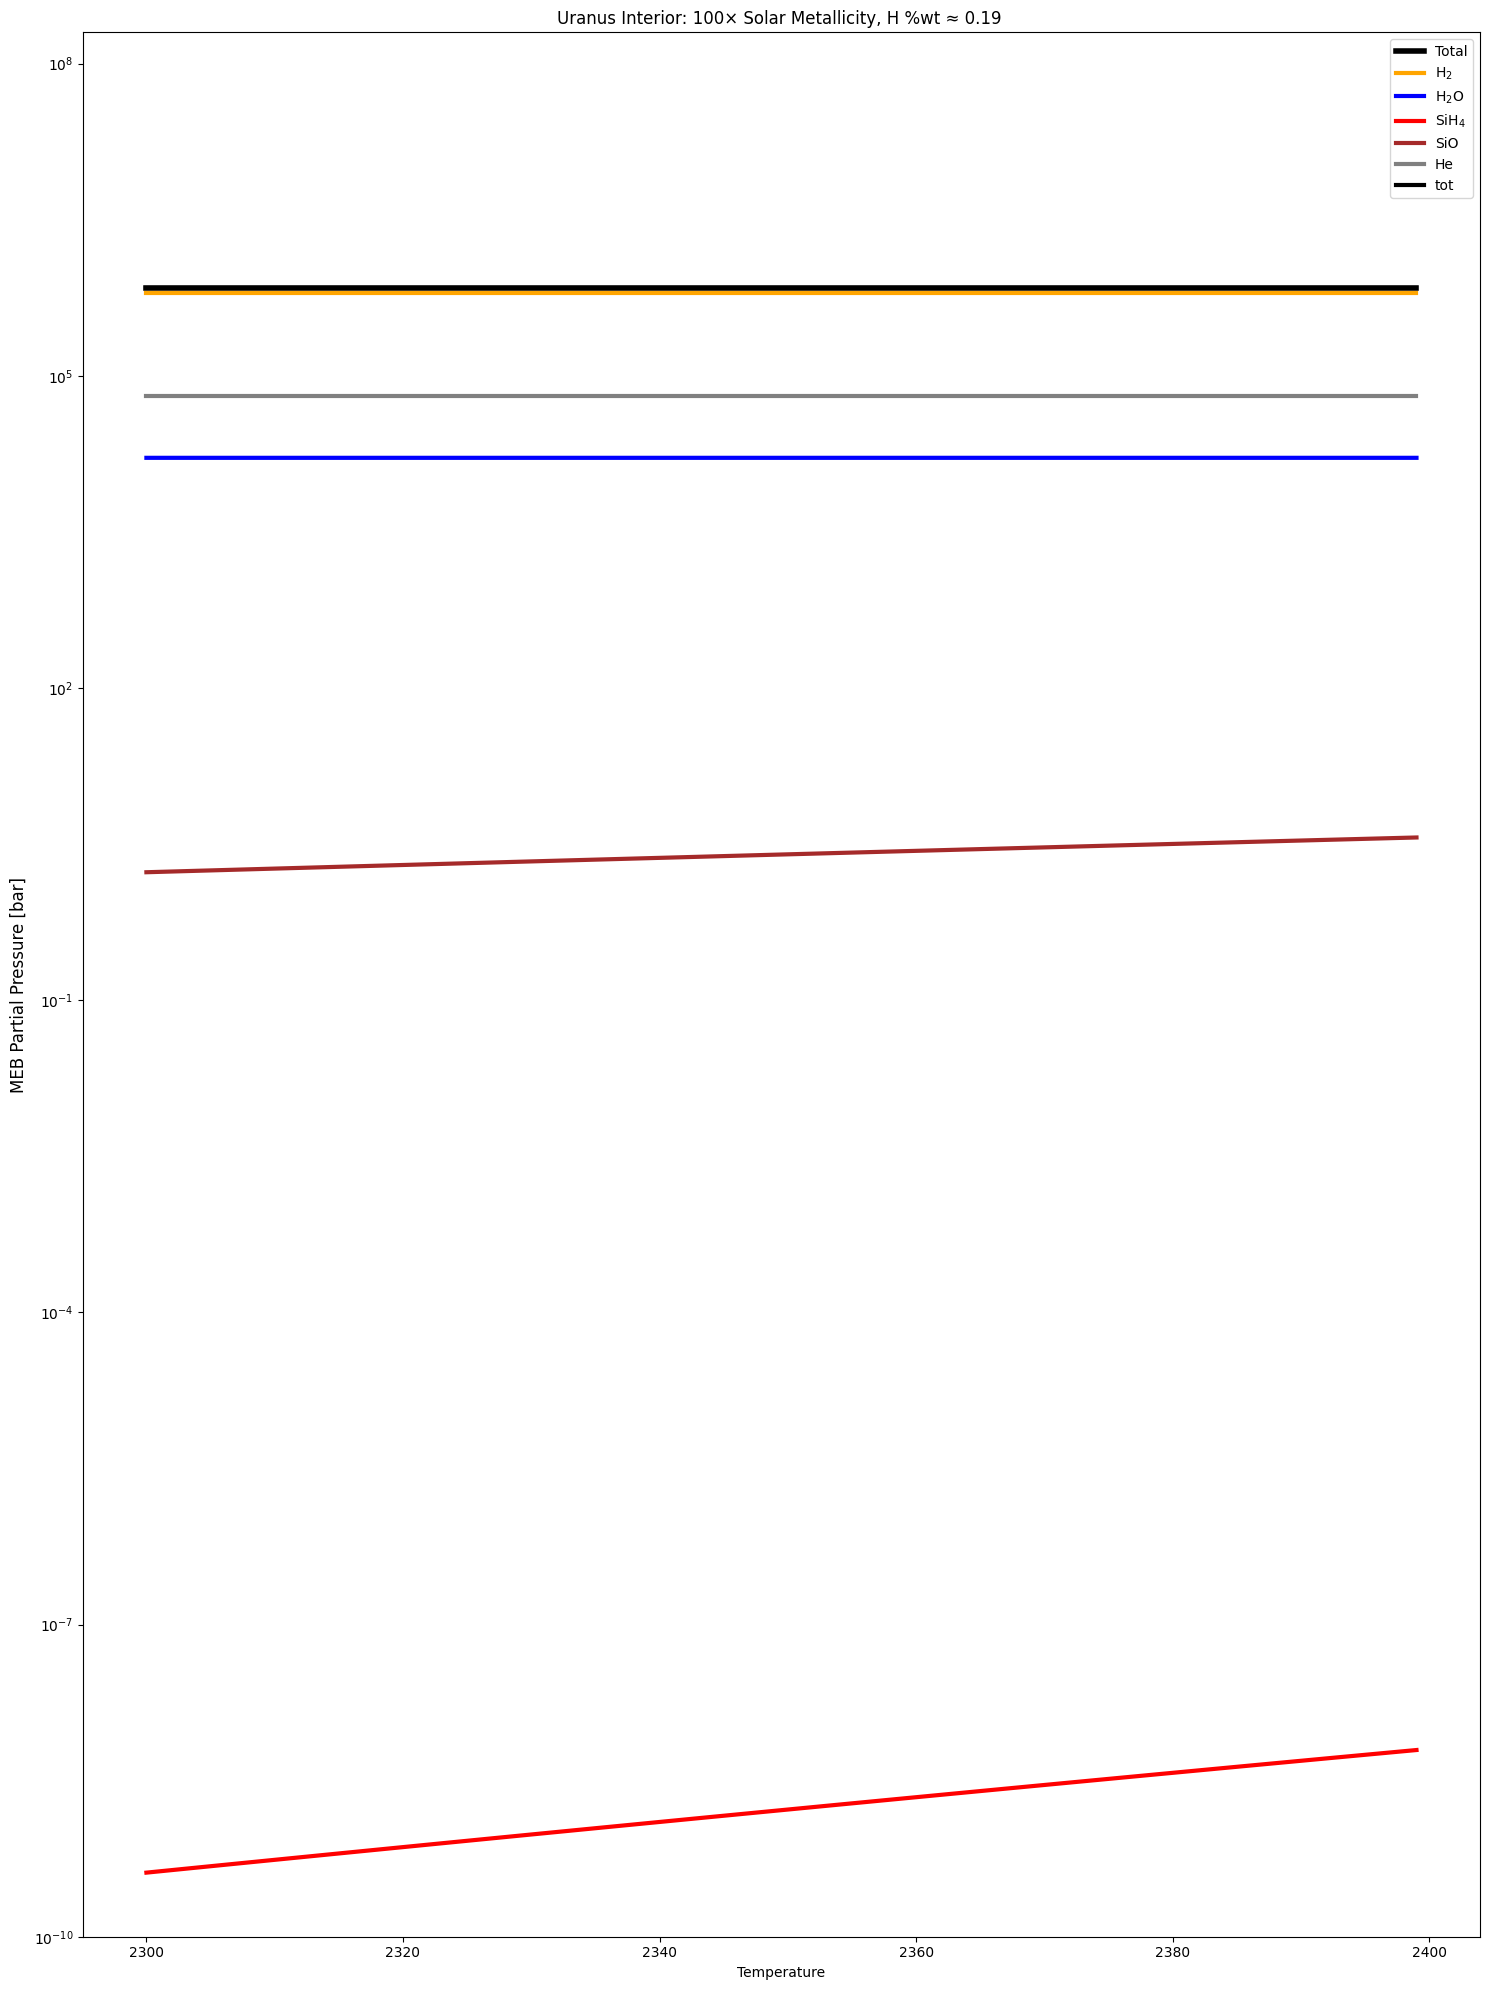

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(15, 20))

ax.plot(core_temperature, tot_pressure_magma_sol_real, color=color_tot, lw=4, ls="-", label="Total")
ax.plot(core_temperature, H2_pressure_magma_sol_real, color=color_H2, lw=3, ls="-", label="H$_2$")
ax.plot(core_temperature, H2O_pressure_magma_sol_real, color=color_H2O, lw=3, ls="-", label="H$_2$O")
ax.plot(core_temperature, SiH4_pressure_magma_sol_real, color=color_SiH4, lw=3, ls="-", label="SiH$_4$")
ax.plot(core_temperature, SiO_pressure_magma_sol_real, color=color_SiO, lw=3, ls="-", label="SiO")
ax.plot(core_temperature, He_pressure_magma_sol_real, color=color_He, lw=3, ls="-", label="He")
ax.plot(core_temperature, tot_pressure_magma_sol_real, color=color_tot, lw=3, ls="-", label="tot")

ax.set_title(r"(a) Real gas")
ax.set_ylim([1e-10, 2e8])
ax.set_yscale("log")
ax.set_xlabel(r"Temperature", fontsize=10)
ax.set_ylabel(r"MEB Partial Pressure [bar]", fontsize=12)
ax.get_xaxis().set_major_formatter(ScalarFormatter())

ax.legend(fontsize=10, loc='best') 
        
plt.tight_layout()
title = f"Uranus Interior: {100:.0f}× Solar Metallicity, H %wt ≈ {H_perc:.2f} "
filename = f"./image_Nettelman_U2/uranus_{100:.0f}xperc_{H_perc:.2f}.png"

plt.title(title)
#plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

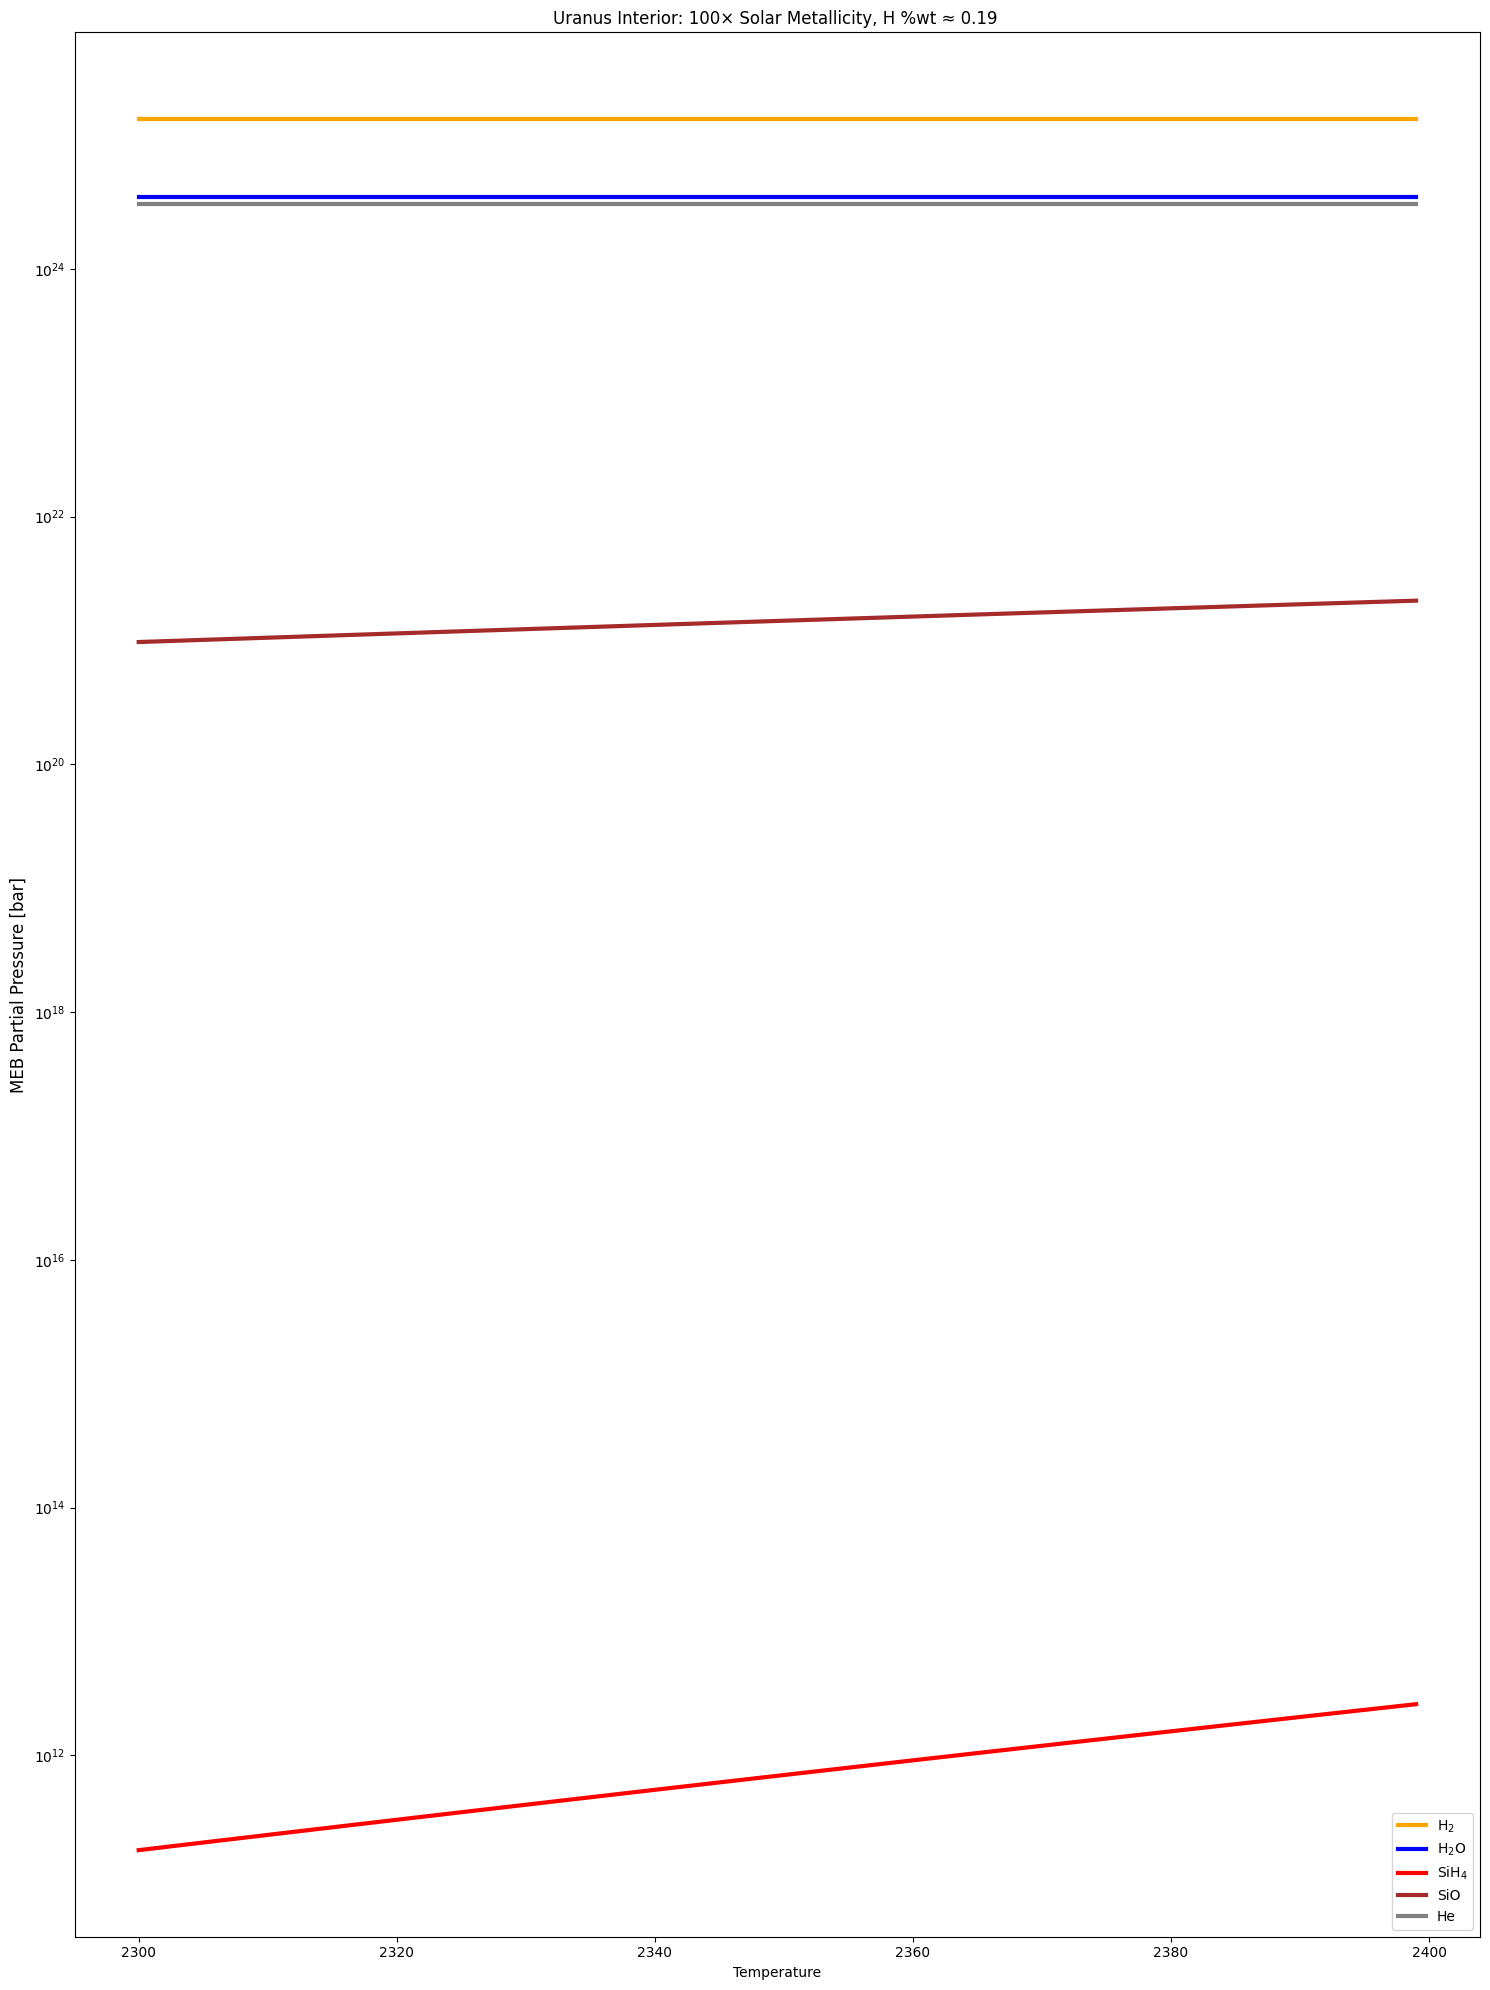

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(15, 20))

ax.plot(core_temperature, H2_mass_magma_sol_real, color=color_H2, lw=3, ls="-", label="H$_2$")
ax.plot(core_temperature, H2O_mass_magma_sol_real, color=color_H2O, lw=3, ls="-", label="H$_2$O")
ax.plot(core_temperature, SiH4_mass_magma_sol_real, color=color_SiH4, lw=3, ls="-", label="SiH$_4$")
ax.plot(core_temperature, SiO_mass_magma_sol_real, color=color_SiO, lw=3, ls="-", label="SiO")
ax.plot(core_temperature, He_mass_magma_sol_real, color=color_He, lw=3, ls="-", label="He")

ax.set_title(r"(a) Real gas")
#ax.set_ylim([1e-10, 2e8])
ax.set_yscale("log")
ax.set_xlabel(r"Temperature", fontsize=10)
ax.set_ylabel(r"MEB Partial Pressure [bar]", fontsize=12)
ax.get_xaxis().set_major_formatter(ScalarFormatter())

ax.legend(fontsize=10, loc='best') 
        
plt.tight_layout()
title = f"Uranus Interior: {100:.0f}× Solar Metallicity, H %wt ≈ {H_perc:.2f} "
filename = f"./image_Nettelman_U2/uranus_{100:.0f}xperc_{H_perc:.2f}.png"

plt.title(title)
#plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

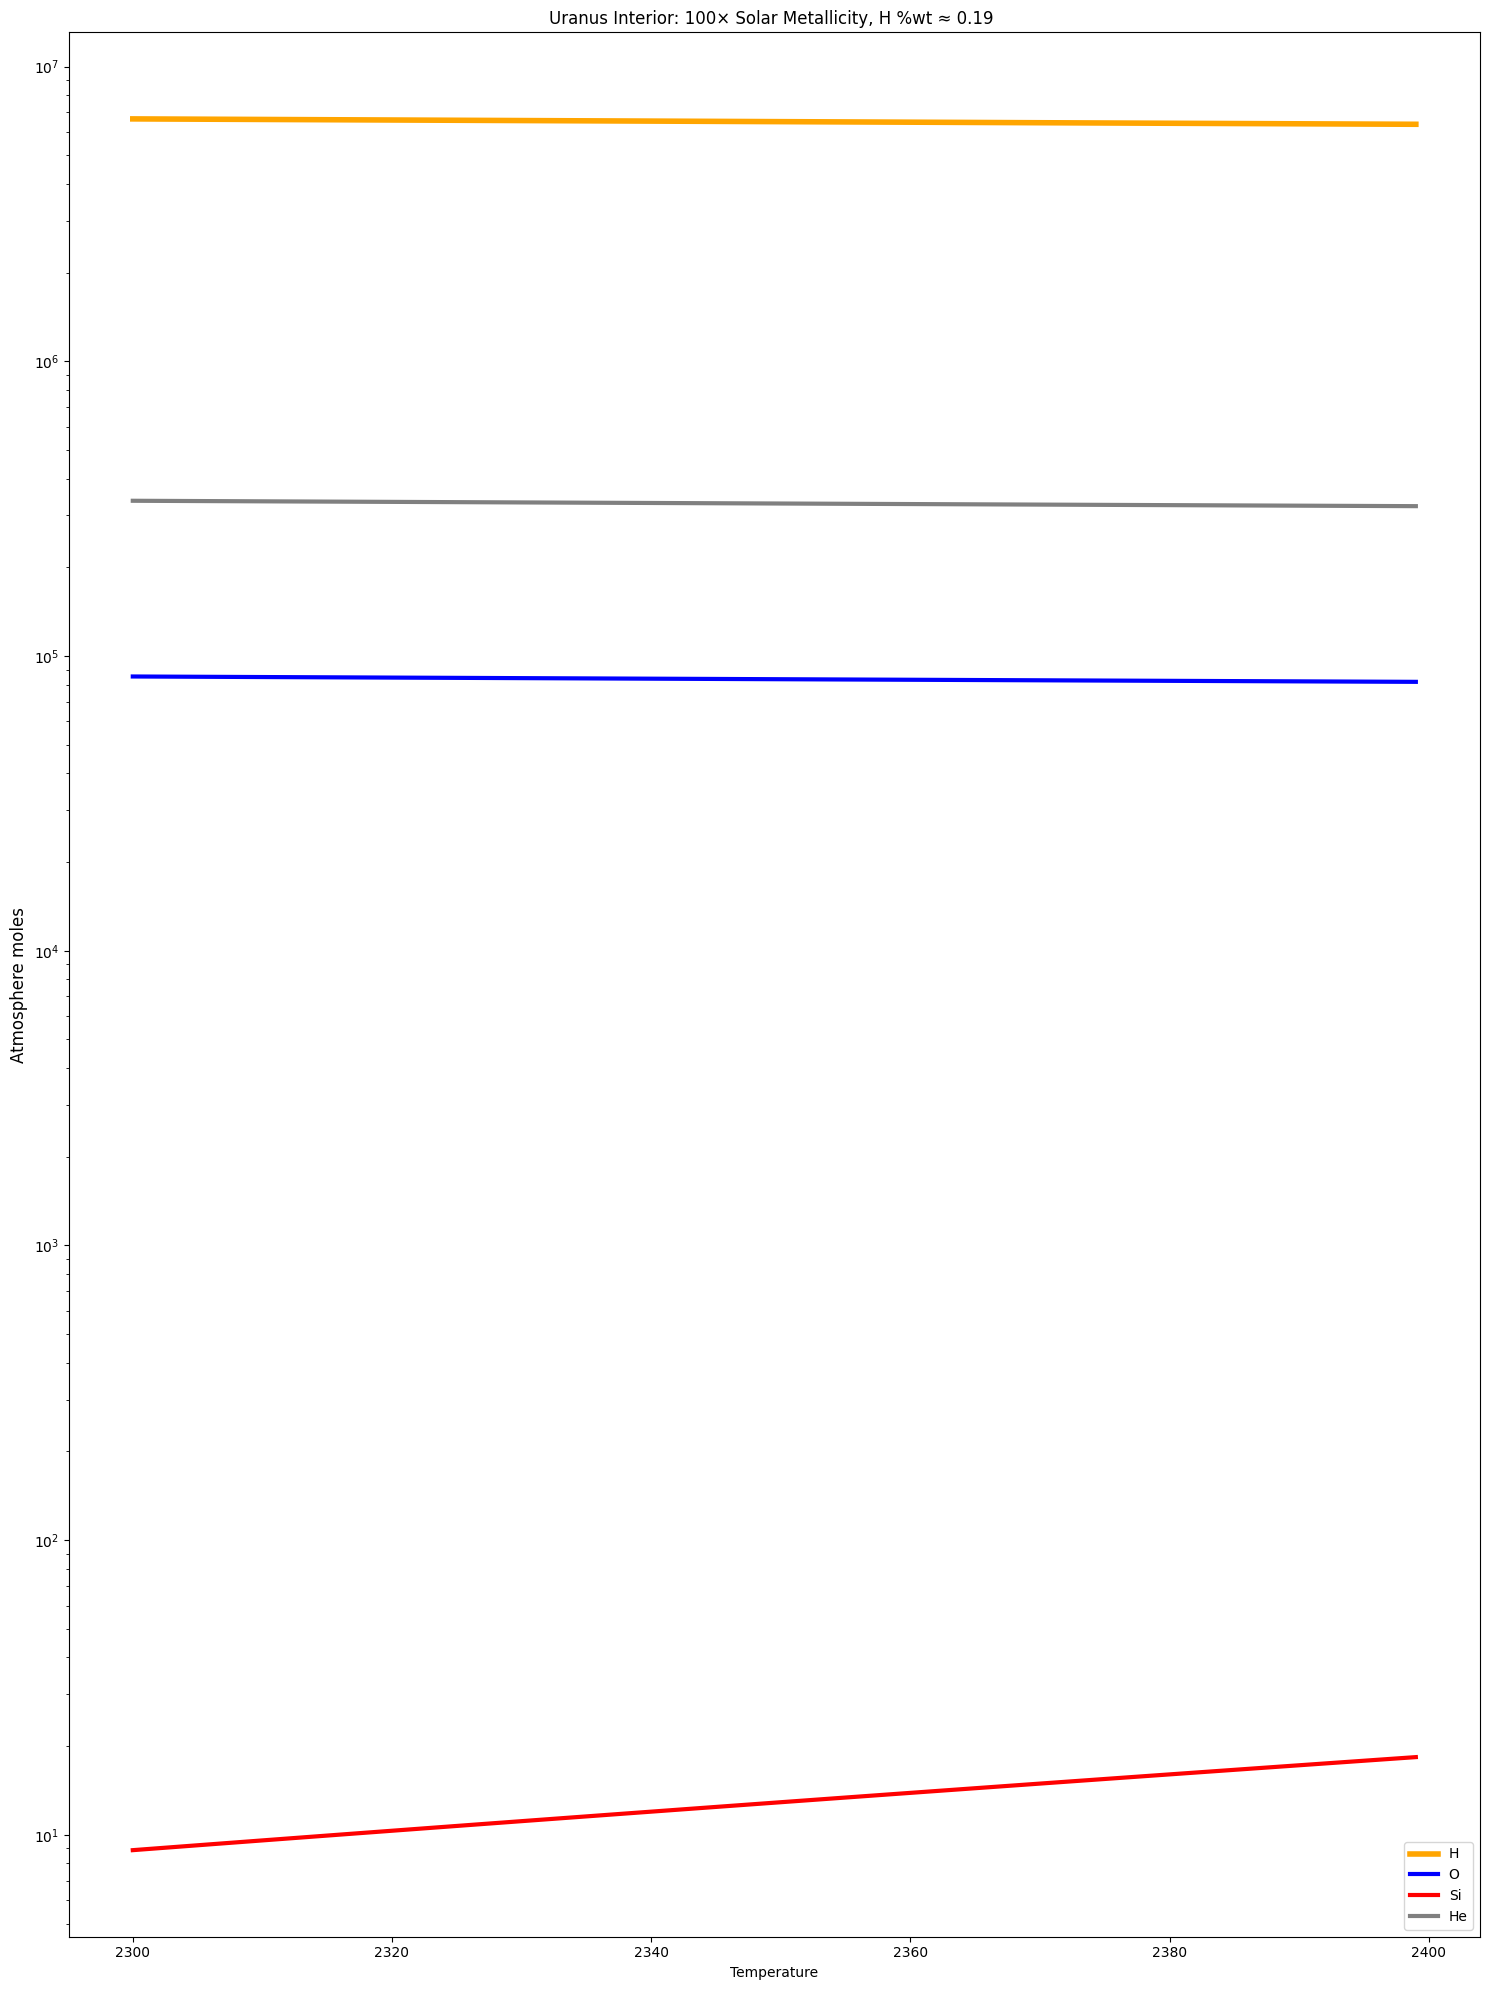

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(15, 20))

ax.plot(core_temperature, H_moles_atm_magma_sol_real, color=color_H, lw=4, ls="-", label="H")
ax.plot(core_temperature, O_moles_atm_magma_sol_real, color=color_O, lw=3, ls="-", label="O")
ax.plot(core_temperature, Si_moles_atm_magma_sol_real, color=color_Si, lw=3, ls="-", label="Si")
ax.plot(core_temperature, He_moles_atm_magma_sol_real, color=color_He, lw=3, ls="-", label="He")

ax.set_title(r"(a) Real gas")
#ax.set_ylim([1e-10, 2e8])
ax.set_yscale("log")
ax.set_xlabel(r"Temperature", fontsize=10)
ax.set_ylabel(r"Atmosphere moles", fontsize=12)
ax.get_xaxis().set_major_formatter(ScalarFormatter())

ax.legend(fontsize=10, loc='best') 
        
plt.tight_layout()
title = f"Uranus Interior: {100:.0f}× Solar Metallicity, H %wt ≈ {H_perc:.2f} "
filename = f"./image_Nettelman_U2/uranus_{100:.0f}xperc_{H_perc:.2f}.png"

plt.title(title)
#plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

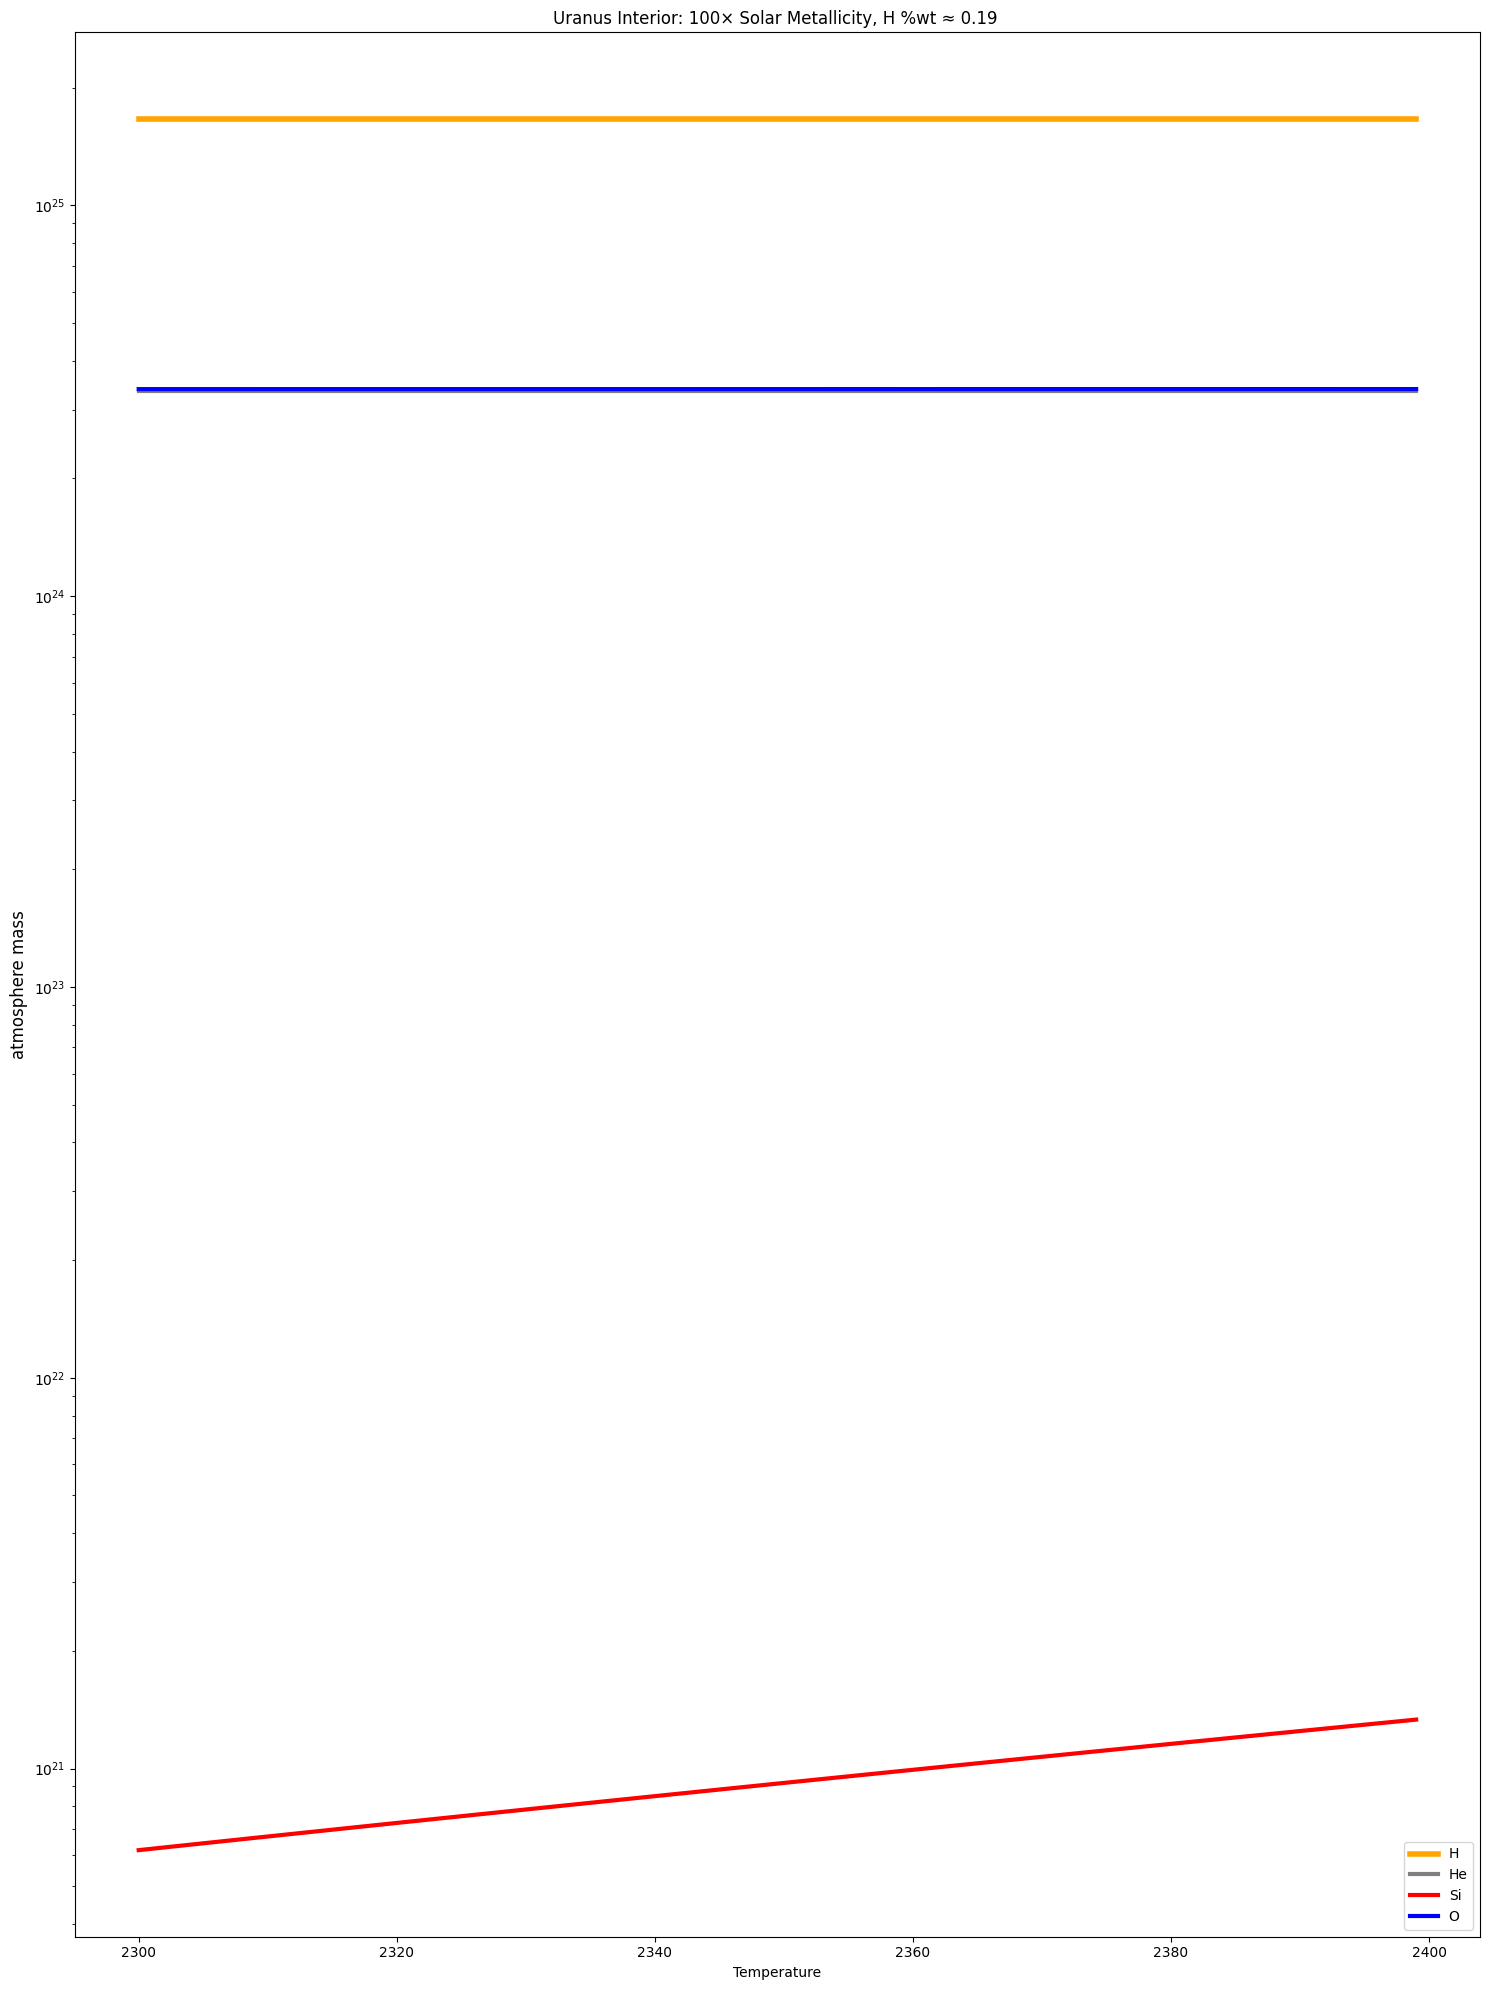

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(15, 20))

ax.plot(core_temperature, H_mass_atm_magma_sol_real, color=color_H, lw=4, ls="-", label="H")
ax.plot(core_temperature, He_mass_atm_magma_sol_real, color=color_He, lw=3, ls="-", label="He")
ax.plot(core_temperature, Si_mass_atm_magma_sol_real, color=color_Si, lw=3, ls="-", label="Si")
ax.plot(core_temperature, O_mass_atm_magma_sol_real, color=color_O, lw=3, ls="-", label="O")

ax.set_title(r"(a) Real gas")
#ax.set_ylim([1e-10, 2e8])
ax.set_yscale("log")
ax.set_xlabel(r"Temperature", fontsize=10)
ax.set_ylabel(r"atmosphere mass", fontsize=12)
ax.get_xaxis().set_major_formatter(ScalarFormatter())

ax.legend(fontsize=10, loc='best') 
        
plt.tight_layout()
title = f"Uranus Interior: {100:.0f}× Solar Metallicity, H %wt ≈ {H_perc:.2f} "
filename = f"./image_Nettelman_U2/uranus_{100:.0f}xperc_{H_perc:.2f}.png"

plt.title(title)
#plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

## H-He-Si-O-C

In [126]:
eos_models = get_eos_models()
sol_models = get_solubility_models()

H2O_g = ChemicalSpecies.create_gas("H2O")
H2O_gs = ChemicalSpecies.create_gas("H2O", solubility=sol_models["H2O_peridotite_sossi23"])
H2O_rgs = ChemicalSpecies.create_gas(
    "H2O",
    activity=eos_models["H2O_cork_holland98"],
    solubility=sol_models["H2O_peridotite_sossi23"],
)

H2_g = ChemicalSpecies.create_gas("H2")
H2_gs = ChemicalSpecies.create_gas("H2", solubility=sol_models["H2_basalt_hirschmann12"])
H2_rgs = ChemicalSpecies.create_gas(
    "H2", activity=eos_models["H2_chabrier21"], solubility=sol_models["H2_basalt_hirschmann12"]
)

O2_g = ChemicalSpecies.create_gas("O2")
O2_rg = ChemicalSpecies.create_gas("O2", activity=eos_models["O2_cs_shi92"])

OSi_g = ChemicalSpecies.create_gas("OSi")
OSi_rg = ChemicalSpecies.create_gas("OSi", activity=eos_models["OSi_rk49_connolly16"])

H4Si_g = ChemicalSpecies.create_gas("H4Si")
H4Si_rg = ChemicalSpecies.create_gas("H4Si", activity=eos_models["H4Si_wang18"])

O2Si_l = ChemicalSpecies.create_condensed("O2Si", state="l")
O2Si_bqz = ChemicalSpecies.create_condensed("O2Si", state="bqz")
CO2_g = ChemicalSpecies.create_gas("CO2")
CO2_gs = ChemicalSpecies.create_gas("CO2", solubility=sol_models["CO2_basalt_dixon95"])
CO2_rgs = ChemicalSpecies.create_gas(
    "CO2", solubility=sol_models["CO2_basalt_dixon95"], activity=eos_models["CO2_cs_shi92"]
)
C_cr = ChemicalSpecies.create_condensed("C", state="cr")

#
CO_g = ChemicalSpecies.create_gas("CO")
CO_gs = ChemicalSpecies.create_gas("CO", solubility=sol_models["CO_basalt_yoshioka19"])
CO_rgs = ChemicalSpecies.create_gas(
    "CO", solubility=sol_models["CO_basalt_yoshioka19"], activity=eos_models["CO_cs_shi92"]
)
#
CH4_g = ChemicalSpecies.create_gas("CH4")
CH4_gs = ChemicalSpecies.create_gas("CH4", solubility=sol_models["CH4_basalt_ardia13"])
CH4_rgs = ChemicalSpecies.create_gas(
    "CH4", solubility=sol_models["CH4_basalt_ardia13"], activity=eos_models["CH4_cs_shi92"]
)
#
N2_g = ChemicalSpecies.create_gas("N2")
N2_gs = ChemicalSpecies.create_gas("N2", solubility=sol_models["N2_basalt_libourel03"])
N2_rgs = ChemicalSpecies.create_gas(
    "N2",solubility=sol_models["N2_basalt_libourel03"],activity=eos_models["N2_cs_saxena87"]
)

NH3_g = ChemicalSpecies.create_gas("NH3")
NH3_rg = ChemicalSpecies.create_gas("H3N", activity=eos_models["H3N_rk49_reid87"])

He_g = ChemicalSpecies.create_gas("He")
He_gs = ChemicalSpecies.create_gas("He", solubility=sol_models["He_basalt_jambon86"])
He_rgs = ChemicalSpecies.create_gas(
    "He", solubility=sol_models["He_basalt_jambon86"], activity=eos_models["He_chabrier21"]
)

species_HHeCNOSi_magma_nosol_ideal = SpeciesNetwork(
    (
        H2O_g, 
        H2_g, 
        O2_g, 
        OSi_g, 
        H4Si_g, 
        O2Si_l,  
        He_g,
        CO2_g, 
        CO_g, 
        CH4_g
        )
)
species_HHeCNOSi_magma_sol_ideal = SpeciesNetwork(
    (
        H2O_gs, 
        H2_gs, 
        O2_g, 
        OSi_g, 
        H4Si_g, 
        O2Si_l,
        He_gs,
        CO2_gs, 
        CO_gs, 
        CH4_gs
        )
)
species_HHeCNOSi_magma_sol_real = SpeciesNetwork(
    (
        H2O_rgs,
        H2_rgs,
        O2_rg,
        OSi_rg,
        H4Si_rg,
        O2Si_l,
        He_rgs,
        CO2_rgs, 
        CO_rgs, 
        CH4_rgs
    )
)

In [134]:
# Overall structure 
R_earth = 6.371e6
R_uranus = 3.939 * R_earth
M_earth = 5.972e24 #kg
M_uranus = 14.536 * M_earth

# Percentages
H_He_perc = 0.14
H2O_perc = 0.83
SiO2_perc = 0.03

#Amount of hydrogen and helium
H_perc = 0.705*H_He_perc + 2 * 1.00794 / ( 15.999 + 2 * 1.00794) * H2O_perc 
h_kg = H_perc*M_uranus

He_perc = 0.275*H_He_perc
he_kg = He_perc*M_uranus

# Rocky Core 
M_envelope = H_He_perc * M_uranus
M_core = M_uranus - M_envelope
core_mantle_melt_fraction = 0
R_core = 0.76*R_uranus
core_temperature = 2400
#core_temperature = np.linspace(2300, 2400, 100, endpoint=False)

# Try two endmember metallicity cases
init_metallicitys = [85]  # metallicity in x solar units

# Initialize EquilibriumModel objects outside of the loop 
model_magma_nosol_ideal = EquilibriumModel(species_HHeCNOSi_magma_nosol_ideal)
model_magma_sol_ideal = EquilibriumModel(species_HHeCNOSi_magma_sol_ideal)
model_magma_sol_real = EquilibriumModel(species_HHeCNOSi_magma_sol_real)

for init_metallicity in init_metallicitys:

    planet = Planet(
        temperature=core_temperature,
        planet_mass=M_core,
        mantle_melt_fraction=0,
        surface_radius=R_core,
    )

    # Lodders et al. (2009) Springer book chapter - Table 8
    scale_percent_metallicity = H_masspercent_lodders09 + He_masspercent_lodders09 + init_metallicity * (
        C_masspercent_lodders09 + N_masspercent_lodders09 + 
        Si_masspercent_lodders09 + 
        O_masspercent_lodders09)

    c_kg = M_envelope * init_metallicity * C_masspercent_lodders09 / scale_percent_metallicity
    n_kg = M_envelope * init_metallicity * N_masspercent_lodders09 / scale_percent_metallicity
    o_kg = M_envelope * init_metallicity * O_masspercent_lodders09 / scale_percent_metallicity
    si_kg = M_envelope * init_metallicity * Si_masspercent_lodders09 / scale_percent_metallicity
    
    # Palme and O'Neill (2014) Treatise on Geochemistry - Table 3
    o_kg_magma = M_core * O_massfraction_palme14
    si_kg_magma = M_core * Si_massfraction_palme14

    mass_constraints = {
        "H": h_kg,
        "He": he_kg,
        "C": c_kg,
#        "N": n_kg,
        "O": o_kg + o_kg_magma,
        "Si": si_kg + si_kg_magma,
    }

    # Magma - No solubility - Ideal Gas
    model_magma_nosol_ideal.solve(
        state=planet,
        mass_constraints=mass_constraints,
        solver_type="basic",
    )
    output_magma_nosol_ideal = model_magma_nosol_ideal.output
    # output_magma_nosol_ideal.quick_look()
    output_magma_nosol_ideal.to_excel(
        f"HHeCOSi_atmosphere_nosol_ideal_{init_metallicity}xsolar"
    )

    # Magma - Solubility - Ideal Gas
    initial_log_number_moles = output_magma_nosol_ideal.log_number_moles
    model_magma_sol_ideal.solve(
        state=planet,
        mass_constraints=mass_constraints,
        solver_type="basic",
        initial_log_number_moles=initial_log_number_moles,
    )
    output_magma_sol_ideal = model_magma_sol_ideal.output
    # output_magma_sol_ideal.quick_look()
    output_magma_sol_ideal.to_excel(
        f"HHeCOSi_atmosphere_sol_ideal_{init_metallicity}xsolar"
    )

    # Magma - Solubility - Real Gas
    initial_log_number_moles = output_magma_sol_ideal.log_number_moles
    model_magma_sol_real.solve(
        state=planet,
        mass_constraints=mass_constraints,
        solver_type="basic",
        multistart=50,
        initial_log_number_moles=initial_log_number_moles,
    )
    output_magma_sol_real = model_magma_sol_real.output
    output_magma_sol_real.quick_look()
    output_magma_sol_real.to_excel(
        f"HHeCOSi_atmosphere_sol_real_{init_metallicity}xsolar"
    )

[13:47:48 - atmodeller.classes             - INFO     ] - species_network = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'He_g: IdealGas, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility')
[13:47:48 - atmodeller.classes             - INFO     ] - Thermodynamic data requires temperatures between 1996 K and 6000 K
[13:47:48 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 2.0 OSi_g = 1.0 H4Si_g + 1.0 O2Si_l',
 1: '4.0 H2_g + 2.0 OSi_g = 1.0 O2_g + 2.0 H4Si_g',
 2: '3.0 H2_g + 1.0 OSi_g = 1.0 H2O_g + 1.0 H4Si_g',
 3: '1.0 H4Si_g + 1.0 CO2_g = 2.0 H2_g + 1.0 OSi_g + 1.0 CO_g',
 4: '2.0 H4Si_g + 1.0 CO2_g = 2.0 H2_g + 2.0 OSi_g + 1.0 CH4_g'}
[13:47:48 - atmodeller.classes             - INFO     ] - species_network = ('H2O_g: IdealGas, Solubil

TypeError: EquilibriumModel.solve() got an unexpected keyword argument 'multistart'